# Imports

In [ ]:
!pip install torch torchvision

In [ ]:
import os
import re
import random
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from google.colab import drive

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.cuda.amp import GradScaler, autocast

import torchvision
import torchvision.transforms as T
from torchvision.models.detection import FasterRCNN, fasterrcnn_resnet50_fpn
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import yaml

Importing dataset from Google Drive

In [ ]:
drive.mount('/content/drive')
root_dir = '/content/drive/My Drive'

# project_dir = f'{root_dir}/Semester 5/Deep Learning/final project/'
project_dir = f'{root_dir}/final project'

print("Files in project folder:", os.listdir(project_dir))

dataset_dir = f'{project_dir}/dataset/car'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Localization

### Preprocessing / Labeling

In [ ]:
class SignDataset(Dataset):
    def __init__(self, project_dir_, input_size=(256, 256), transforms=None):
        self.image_dir = os.path.join(project_dir_, 'Images')
        self.annotation_dir = os.path.join(project_dir_, 'Annotations')
        self.input_size = input_size
        self.transforms = transforms

        if not os.path.exists(self.image_dir):
            raise FileNotFoundError(f"Image directory does not exist: {self.image_dir}")
        if not os.path.exists(self.annotation_dir):
            raise FileNotFoundError(f"Annotation directory does not exist: {self.annotation_dir}")

        self.image_files = [f for f in os.listdir(self.image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if not self.image_files:
            raise ValueError(f"No image files found in {self.image_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image file not found or could not be read: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_height, original_width = image.shape[:2]

        annotation_name = os.path.splitext(image_name)[0] + '.json'
        annotation_path = os.path.join(self.annotation_dir, annotation_name)
        if not os.path.exists(annotation_path):
            raise FileNotFoundError(f"Annotation file not found for image: {image_path}")

        with open(annotation_path, 'r') as f:
            bbox_data = json.load(f)

        boxes = []
        labels = []
        for obj in bbox_data.get('objects', []):
            bbox = obj.get('bbox', {})
            try:
                xmin = float(bbox['xmin'])
                ymin = float(bbox['ymin'])
                xmax = float(bbox['xmax'])
                ymax = float(bbox['ymax'])
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(1)
            except (KeyError, TypeError, ValueError):
                continue

        image = cv2.resize(image, self.input_size)
        image = image / 255.0

        if len(boxes) > 0:
            boxes = np.array(boxes, dtype=np.float32)
            scale_x = self.input_size[0] / original_width
            scale_y = self.input_size[1] / original_height
            boxes[:, [0, 2]] = boxes[:, [0, 2]] * scale_x
            boxes[:, [1, 3]] = boxes[:, [1, 3]] * scale_y
        else:
            boxes = np.empty((0, 4), dtype=np.float32)
        labels = np.array(labels, dtype=np.int64) if len(labels) > 0 else np.empty((0,), dtype=np.int64)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        if self.transforms:
            image = self.transforms(image)

        if not self.transforms:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # (C, H, W)

        return image, target

### Model

In [ ]:
!pip install timm # for DINO model

In [ ]:
import timm

class FasterRCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(FasterRCNN, self).__init__()

        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True, features_only=True)

        backbone_out_channels = self.backbone[-1].out_channels

        self.fpn = torchvision.ops.FeaturePyramidNetwork([backbone_out_channels], out_channels=256)

        anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                           aspect_ratios=((0.5, 1.0, 2.0),))

        self.rpn = torchvision.models.detection.rpn.RPNHead(backbone_out_channels, anchor_generator.num_anchors_per_location()[0])
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                        output_size=7,
                                                        sampling_ratio=2)
        self.roi_heads = torchvision.models.detection.roi_heads.RoIHeads(
            roi_pooler,
            num_classes,
            torchvision.models.detection.transform.GeneralizedRCNNTransform(min_size=800, max_size=1333,
                                                                          image_mean=[0.485, 0.456, 0.406],
                                                                          image_std=[0.229, 0.224, 0.225]),
            self.rpn,
            backbone_out_channels,
            torchvision.models.detection.faster_rcnn.FastRCNNPredictor(backbone_out_channels, num_classes))

    def forward(self, images, targets=None):
        features = self.backbone(images)

        fpn_features = self.fpn(features)

        proposals, proposal_losses = self.rpn(images, fpn_features, targets)
        detections, detector_losses = self.roi_heads(fpn_features, proposals, images.image_sizes, targets)

        if self.training:
            return dict(loss_rpn_box_reg=proposal_losses['loss_rpn_box_reg'],
                        loss_rpn_objectness=proposal_losses['loss_rpn_objectness'],
                        loss_classifier=detector_losses['loss_classifier'],
                        loss_box_reg=detector_losses['loss_box_reg'])
        return detections

### Training

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

full_dataset = SignDataset(project_dir=f'{project_dir}/localization/dataset', input_size=(512, 512))

subset_size = 2000

subset_indices = list(range(min(subset_size, len(full_dataset))))

subset_dataset = Subset(full_dataset, subset_indices)

def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1):
    total_size = len(dataset)
    indices = list(range(total_size))
    random.seed(42)
    random.shuffle(indices)

    train_end = int(train_ratio * total_size)
    val_end = train_end + int(val_ratio * total_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(subset_dataset)

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

batch_size = 4
num_workers = 4

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, collate_fn=collate_fn
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

num_classes = 2
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

scaler = GradScaler()

def train_one_epoch(model, optimizer, data_loader, device, epoch, scaler, print_freq=50):
    model.train()
    total_loss = 0
    for batch_idx, (images, targets) in enumerate(data_loader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        with autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += losses.item()
        if batch_idx % print_freq == 0:
            print(f"Epoch [{epoch+1}], Step [{batch_idx}/{len(data_loader)}], Loss: {losses.item():.4f}")

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch+1}] Average Loss: {avg_loss:.4f}")
    return avg_loss

def evaluate(model, data_loader, device):
    model.eval()
    total_iou = 0
    num_batches = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)
            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].detach().cpu()
                gt_boxes = targets[i]['boxes'].cpu()
                if pred_boxes.shape[0] == 0 or gt_boxes.shape[0] == 0:
                    continue
                ious = torchvision.ops.box_iou(pred_boxes, gt_boxes)
                max_iou_per_pred = ious.max(dim=1)[0]
                mean_iou = max_iou_per_pred.mean().item()
                total_iou += mean_iou
                num_batches += 1
    mean_iou = total_iou / num_batches if num_batches > 0 else 0
    print(f"Validation Mean IoU: {mean_iou:.4f}")
    return mean_iou

In [ ]:
num_epochs = 60

best_val_iou = 0
train_losses = []
val_ious = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch, scaler)
    val_iou = evaluate(model, val_loader, device)

    train_losses.append(train_loss)
    val_ious.append(val_iou)

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), f'{project_dir}/localization/model/best_model.pth')
        print(f"Best model saved with Validation Mean IoU: {best_val_iou:.4f}")
    scheduler.step(val_iou)

print("Training complete")

### Test model

Testing model on image

In [ ]:
def create_visualizations_from_test(
    test_dataset, model_path, output_dir, device, num_samples=1, input_size=(512, 512)
):
    os.makedirs(output_dir, exist_ok=True)

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    indices = random.sample(range(len(test_dataset)), num_samples)

    for idx in indices:
        image, target = test_dataset[idx]
        image_np = (image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

        image_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(image_tensor)

        predicted_boxes = outputs[0]['boxes'].cpu().numpy()
        predicted_scores = outputs[0]['scores'].cpu().numpy()

        predicted_data = {
            "predicted_boxes": predicted_boxes.tolist(),
            "scores": predicted_scores.tolist()
        }
        json_output_path = os.path.join(output_dir, f"sample_{idx}_predictions.json")
        with open(json_output_path, 'w') as f:
            json.dump(predicted_data, f, indent=4)

        prediction_image = image_np.copy()
        for box in predicted_boxes:
            xmin, ymin, xmax, ymax = map(int, box)
            cv2.rectangle(prediction_image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

        prediction_image_path = os.path.join(output_dir, f"sample_{idx}_prediction.jpg")
        cv2.imwrite(prediction_image_path, cv2.cvtColor(prediction_image, cv2.COLOR_RGB2BGR))

        ground_truth_image = image_np.copy()
        ground_truth_boxes = target['boxes'].cpu().numpy()
        for box in ground_truth_boxes:
            xmin, ymin, xmax, ymax = map(int, box)
            cv2.rectangle(ground_truth_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        ground_truth_image_path = os.path.join(output_dir, f"sample_{idx}_ground_truth.jpg")
        cv2.imwrite(ground_truth_image_path, cv2.cvtColor(ground_truth_image, cv2.COLOR_RGB2BGR))

        for i, box in enumerate(predicted_boxes):
            xmin, ymin, xmax, ymax = map(int, box)
            width = xmax - xmin
            height = ymax - ymin
            max_side = max(width, height)
            center_x = (xmin + xmax) // 2
            center_y = (ymin + ymax) // 2
            half_side = max_side // 2
            crop_x1 = max(0, center_x - half_side)
            crop_y1 = max(0, center_y - half_side)
            crop_x2 = min(image_np.shape[1], center_x + half_side)
            crop_y2 = min(image_np.shape[0], center_y + half_side)
            cropped_image = image_np[crop_y1:crop_y2, crop_x1:crop_x2]
            cropped_image_path = os.path.join(output_dir, f"sample_{idx}_pred_{i}_cropped.jpg")
            cv2.imwrite(cropped_image_path, cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))

        print(f"Saved ground truth, prediction visualizations, and cropped images for test sample {idx} in {output_dir}")

test_output_dir = f"{project_dir}/localization/visualizations/test_results"
create_visualizations_from_test(
    test_dataset=test_dataset,
    model_path = f'{project_dir}/localization/model/final_best_model.pth',
    output_dir=test_output_dir,
    device=device,
    num_samples=5,
    input_size=(512, 512)
)

Test model on video

In [ ]:
def create_visualizations_from_video(
    video_path, trained_model, output_dir, cropped_output_dir, device, input_size=(512, 512), min_area=1024.0
):
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(cropped_output_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    frame_idx = 0

    even_odd = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        even_odd+=1
        if even_odd%2 == 0:
          frame_idx += 1
          continue

        raw_frame_path = os.path.join(output_dir, f"frame_{frame_idx}_raw.jpg")
        cv2.imwrite(raw_frame_path, frame)

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image_tensor = torch.tensor(frame_rgb).float().permute(2, 0, 1) / 255.0
        image_tensor = image_tensor.unsqueeze(0).to(device)

        trained_model.eval()
        with torch.no_grad():
            outputs = trained_model(image_tensor)

        predicted_boxes = outputs[0]['boxes'].cpu().numpy()
        predicted_scores = outputs[0]['scores'].cpu().numpy()

        predicted_data = {
            "predicted_boxes": predicted_boxes.tolist(),
            "scores": predicted_scores.tolist()
        }
        json_output_path = os.path.join(output_dir, f"frame_{frame_idx}_predictions.json")
        with open(json_output_path, 'w') as f:
            json.dump(predicted_data, f, indent=4)

        prediction_image = frame_rgb.copy()
        for box in predicted_boxes:
            xmin, ymin, xmax, ymax = map(int, box)
            width = xmax - xmin
            height = ymax - ymin

            if width * height >= min_area:
                cv2.rectangle(prediction_image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

        prediction_image_path = os.path.join(output_dir, f"frame_{frame_idx}_prediction.jpg")
        cv2.imwrite(prediction_image_path, cv2.cvtColor(prediction_image, cv2.COLOR_RGB2BGR))

        for i, box in enumerate(predicted_boxes):
            xmin, ymin, xmax, ymax = map(int, box)

            width = xmax - xmin
            height = ymax - ymin

            if width * height < min_area:
                continue

            max_side = max(width, height)
            center_x = (xmin + xmax) // 2
            center_y = (ymin + ymax) // 2

            half_side = max_side // 2
            crop_x1 = max(0, center_x - half_side)
            crop_y1 = max(0, center_y - half_side)
            crop_x2 = min(frame_rgb.shape[1], center_x + half_side)
            crop_y2 = min(frame_rgb.shape[0], center_y + half_side)

            cropped_image = frame_rgb[crop_y1:crop_y2, crop_x1:crop_x2]

            if cropped_image.shape[0] * cropped_image.shape[1] >= min_area:
                cropped_image_path = os.path.join(
                    cropped_output_dir, f"frame_{frame_idx}_pred_{i}_cropped.jpg"
                )
                cv2.imwrite(cropped_image_path, cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))

        print(f"Processed and saved frame {frame_idx}.")

        frame_idx += 1

    cap.release()
    print(f"Finished processing the video. Frames saved in {output_dir} and cropped images in {cropped_output_dir}.")

model_path = f"{project_dir}/localization/model/final_best_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = fasterrcnn_resnet50_fpn(pretrained=False)

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

video_path = f"{project_dir}/dataset/new_deep_learning_video_out_cropped.mp4"
output_dir = f"{project_dir}/localization/visualizations/high_res_def"
cropped_output_dir = f"{project_dir}/localization/visualizations/high_res_def"

create_visualizations_from_video(
    video_path=video_path,
    trained_model=model,
    output_dir=output_dir,
    cropped_output_dir=cropped_output_dir,
    device=device,
    input_size=(512, 512)
)

# Classification

### Preprocessing / Model / Early Stopping

In [ ]:
class ImageLabelDataset(Dataset):
    def __init__(self, image_dir, label_dir, class_names, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.class_names = class_names
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]

        self.valid_image_files = []
        for idx, image_file in enumerate(self.image_files):
            print(f'\rImage {idx}/{len(self.image_files)}: {image_file}', end='')

            label_file = image_file.replace('.jpg', '.txt').replace('.png', '.txt')
            label_path = os.path.join(self.label_dir, label_file)

            try:
                with open(label_path, 'r') as f:
                    line_cnt = sum(1 for _ in f)
                    if line_cnt == 1:
                        self.valid_image_files.append(image_file)
            except FileNotFoundError:
                print(f"Label file not found: {label_path}")

    def __len__(self):
        return len(self.valid_image_files)

    def __getitem__(self, idx):
        image_file = self.valid_image_files[idx]
        label_file = image_file.replace('.jpg', '.txt').replace('.png', '.txt')

        image_path = os.path.join(self.image_dir, image_file)
        label_path = os.path.join(self.label_dir, label_file)

        image = Image.open(image_path).convert('RGB')

        with open(label_path, 'r') as f:
            label = int([line.strip().split() for line in f.readlines()][0][0])

        one_hot_label = F.one_hot(torch.tensor(label), num_classes=len(self.class_names))

        if self.transform:
            image = self.transform(image)

        return image, one_hot_label.float()


In [ ]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=15):
        super(TrafficSignCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.resblock = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128)
        )

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        residual = x
        x = F.relu(self.resblock(x) + residual)

        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
class EarlyStopping():
    def __init__(self, patience=20, min_delta=0, save_path=f'{project_dir}/classification/best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.save_path = save_path
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

### Load dataset and Model

In [ ]:
with open(f'{dataset_dir}/data.yaml', 'r') as f:
    data_config = yaml.safe_load(f)

train_image_dir, train_label_dir = f"{dataset_dir}/train/images", f"{dataset_dir}/train/labels"
val_image_dir, val_label_dir = f"{dataset_dir}/valid/images", f"{dataset_dir}/valid/labels"
test_image_dir, test_label_dir = f"{dataset_dir}/test/images", f"{dataset_dir}/test/labels"

class_names = data_config['names']

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalization using imagenet stats
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalization using imagenet stats
])

train_dataset = ImageLabelDataset(train_image_dir, train_label_dir, class_names, transform=train_transform)
val_dataset = ImageLabelDataset(val_image_dir, val_label_dir, class_names, transform=val_transform)
test_dataset = ImageLabelDataset(test_image_dir, test_label_dir, class_names, transform=val_transform)

Image 637/638: road673_png.rf.4180f0a6afa7416d52c729d8b9305d75.jpg

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=32)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = TrafficSignCNN(len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Training loop
num_epochs = 100
early_stopping = EarlyStopping(patience = 5, min_delta=0.01, save_path=f'{project_dir}/classification/res_net_best_model.pth')

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

# if os.path.exists(early_stopping.save_path):
#     model.load_state_dict(torch.load(early_stopping.save_path))
#     print(f"Loaded model from {early_stopping.save_path}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Train

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (train_images, train_labels) in enumerate(train_dataloader):
        print(f'\rBatch {batch_idx}/{len(train_dataloader)} ', end='')

        train_images, train_labels = train_images.to(device), train_labels.to(device)
        optimizer.zero_grad()
        train_outputs = model(train_images)

        loss = criterion(train_outputs, train_labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        # accuracy
        total_train += train_labels.size(0)
        _, predicted = torch.max(train_outputs, dim=1)
        _, actual = torch.max(train_labels, dim=1)
        correct_train += (predicted == actual).sum().item()

    avg_train_loss = running_train_loss / len(train_dataloader)
    train_loss.append(avg_train_loss)
    train_accuracy_epoch = 100 * correct_train / total_train
    train_accuracy.append(train_accuracy_epoch)
    # print(f"\rEpoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss}")

    # validation
    model.eval()
    running_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_idx, (val_images, val_labels) in enumerate(val_dataloader):
            print(f'\rBatch {batch_idx}/{len(val_dataloader)} ', end='')

            val_images, val_labels = val_images.to(device), val_labels.to(device)

            val_outputs = model(val_images)
            running_val_loss += criterion(val_outputs, val_labels).item()

            # accuracy
            total_val += val_labels.size(0)
            _, predicted = torch.max(val_outputs, dim=1)
            _, actual = torch.max(val_labels, dim=1)
            correct_val += (predicted == actual).sum().item()

    avg_val_loss = running_val_loss / len(val_dataloader)
    val_loss.append(avg_val_loss)
    val_accuracy_epoch = 100 * correct_val / total_val
    val_accuracy.append(val_accuracy_epoch)

    print(f"\rEpoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy_epoch}%, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy_epoch}%")

    early_stopping(running_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

Epoch [1/20], Train Loss: 1.681704528229211, Train Accuracy: 44.02155607948804%, Validation Loss: 1.517785451628945, Validation Accuracy: 45.285714285714285%
Epoch [2/20], Train Loss: 1.017885410657493, Train Accuracy: 66.6554395419333%, Validation Loss: 1.3483793870969252, Validation Accuracy: 59.42857142857143%
Epoch [3/20], Train Loss: 0.7854257652195551, Train Accuracy: 74.57056247894914%, Validation Loss: 0.6986783448268067, Validation Accuracy: 76.71428571428571%
Epoch [4/20], Train Loss: 0.6652821686960035, Train Accuracy: 78.78073425395756%, Validation Loss: 0.688775306736881, Validation Accuracy: 78.28571428571429%
Epoch [5/20], Train Loss: 0.5841629956999133, Train Accuracy: 81.47524418996295%, Validation Loss: 0.5811285276219926, Validation Accuracy: 79.85714285714286%
Epoch [6/20], Train Loss: 0.47682001898365634, Train Accuracy: 84.001347254968%, Validation Loss: 0.6089243780482899, Validation Accuracy: 81.28571428571429%
Epoch [7/20], Train Loss: 0.4087126174120493, Train

### Plot Results

In [ ]:
file_path = f'{project_dir}/classification/message.txt'

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

pattern = r"Train Loss: ([\d.]+), Train Accuracy: ([\d.]+)%, Validation Loss: ([\d.]+), Validation Accuracy: ([\d.]+)%"

with open(file_path, 'r') as file:
    for line in file:
        match = re.search(pattern, line)
        if match:
            train_losses.append(float(match.group(1)))
            train_accuracies.append(float(match.group(2)))
            val_losses.append(float(match.group(3)))
            val_accuracies.append(float(match.group(4)))

print("Train Losses:", len(train_losses), train_losses)
print("Train Accuracies:", len(train_accuracies), train_accuracies)
print("Validation Losses:", len(val_losses), val_losses)
print("Validation Accuracies:", len(val_accuracies), val_accuracies)

Train Losses: 85 [2.338115720338719, 2.1859382403794156, 2.0920111479297763, 2.004457510927672, 1.9544949454645957, 1.915534064333926, 1.8742608511319725, 1.834181733028863, 1.7935556827052948, 1.7450923560768046, 1.7167114173212359, 1.690179544110452, 1.6705875435183126, 1.596990744272868, 1.5934735831393991, 1.58072990627699, 1.5231565621591383, 1.4901375770568848, 1.4451580207834962, 1.4228632629558604, 1.3498538078800324, 1.3203869570967972, 1.266182755270312, 1.2084234337652884, 1.1863599432412015, 1.0966556636236047, 1.0610047175038246, 1.0325788887598182, 0.9417187750980418, 0.848861426115036, 0.8429026142243417, 0.7884194520852899, 0.7246539961266262, 0.7076151576093448, 0.6526940096450108, 0.6130182855231787, 0.5666011780179957, 0.5216829494763446, 0.5249917959013293, 0.4790490998696255, 0.43693036850421657, 0.4467660661346169, 0.3905256586049193, 0.389868287149296, 0.39001429978237356, 0.33454216135445464, 0.32840859753790724, 0.30771524186736793, 0.2960986168153824, 0.274892

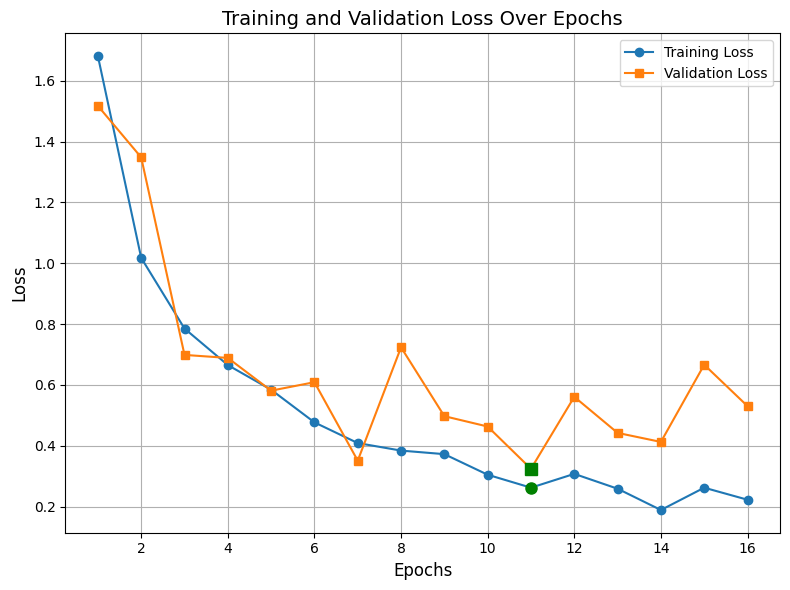

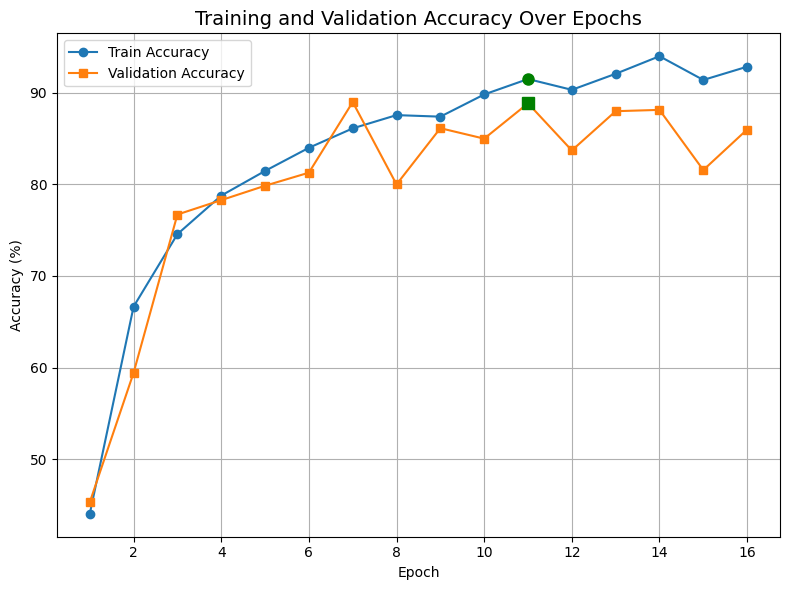

In [ ]:
epochs = range(1, len(train_loss) + 1)
highlight_epoch = np.argmin(val_loss)

# training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')

plt.plot(epochs[highlight_epoch], train_loss[highlight_epoch], 'go', markersize=8)  # green marker for best model
plt.plot(epochs[highlight_epoch], val_loss[highlight_epoch], 'gs', markersize=8)  # green marker for best model

plt.title('Training and Validation Loss Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.show()

# training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='s')

plt.plot(epochs[highlight_epoch], train_accuracy[highlight_epoch], 'go', markersize=8)  # green marker for best model
plt.plot(epochs[highlight_epoch], val_accuracy[highlight_epoch], 'gs', markersize=8)  # green marker for best model

plt.title('Training and Validation Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.show()

### Testing

In [ ]:
def imshow(image, title=None):
    image = image.permute(1, 2, 0).cpu().numpy()

    if image.max() > 1:
        image = image / 255.0

    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


model.load_state_dict(torch.load(early_stopping.save_path)) # load best model
model.eval()
test_loss = 0.0

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_dataloader):
        print(f'\rBatch {batch_idx}/{len(test_dataloader)} ', end='')

        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        test_loss += loss.item()

        all_probs.extend(probabilities.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


        # batch_probs = np.array(all_probs[-1])
        # batch_labels = np.array(all_labels[-1])

        # batch_labels = np.reshape(batch_labels, (1, 15))
        # print(batch_labels)
        # batch_probs = np.reshape(batch_probs, (1, 15))
        # print(batch_probs.shape)
        # roc_auc_batch = roc_auc_score(batch_labels, batch_probs, multi_class='ovr', average='macro')

        # print(f"Batch {batch_idx} ROC AUC Score: {roc_auc_batch:.4f}")

        # for i in range(len(images)):  # Show up to 5 images
        #     image = images[i]
        #     label = labels[i].item()
        #     pred = predicted[i].item()

            # total += 1
            # if pred == label:
            #     correct_predictions += 1

            # title = f"GT: {class_names[int(label)]} - {label} | Pred: {class_names[int(pred)]} - {pred}"
            # imshow(image, title)

Batch 16/17 

### Test results

In [ ]:
accuracy = accuracy_score(np.argmax(all_labels, axis=1), all_preds)
average_test_loss = test_loss / len(test_dataloader)
precision = precision_score(np.argmax(all_labels, axis=1), all_preds, average='macro', zero_division=0)
recall = recall_score(np.argmax(all_labels, axis=1), all_preds, average='macro', zero_division=0)
f1 = f1_score(np.argmax(all_labels, axis=1), all_preds, average='macro', zero_division=0)
# # try:
# print(np.array(all_labels).shape)
# labels = np.reshape(np.array(all_labels), (15, 540))
# probs = np.reshape(np.array(all_probs), (15, 540))
# print(labels)
# print(probs)
# auc_roc = roc_auc_score(labels, probs, multi_class='ovr', average='macro')
# # except ValueError:
# #     auc_roc = None

print(f'Test Loss: {average_test_loss}')
print(f'Accuracy: {accuracy * 100}%')
print(f'Precision: {precision * 100}%')
print(f'Recall: {recall * 100}%')
print(f'F1 Score: {f1 * 100:.2f}%')
# if auc_roc is not None:
#     print(f'AUC-ROC: {auc_roc:.4f}')
# else:
#     print("AUC-ROC: Not available (check probabilities or labels)")

Test Loss: 0.43527018300750675
Accuracy: 86.11111111111111%
Precision: 79.96385352351948%
Recall: 79.14636742272099%
F1 Score: 79.13%


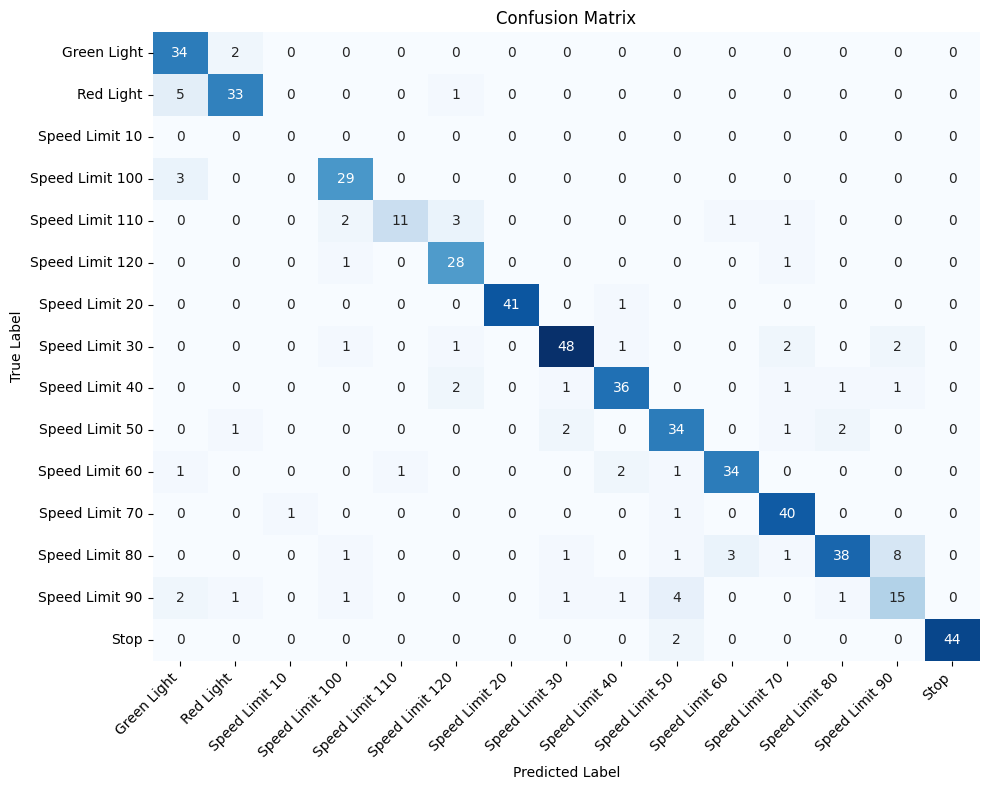

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 'Speed Limit 110',
               'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50',
               'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 80', 'Speed Limit 90', 'Stop']

cm = confusion_matrix(np.argmax(all_labels, axis=1), all_preds, labels=np.arange(15))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Annotate Video

In [ ]:
def has_pred_cropped(filename):
    pattern = r'pred_\d+_cropped'
    return bool(re.search(pattern, filename))

def convert_filename(filename):
    pattern = r'frame_(\d+)_pred_\d+_cropped\.jpg'
    return re.sub(pattern, r'frame_\1_prediction.jpg', filename)

transform = transforms.Compose([
    # transforms.Resize((416, 416)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def test_model_on_images(model, test_image_folder, class_names, device):
    model.to(device)
    model.eval()

    crops = {}
    predictions = []

    for image_name in os.listdir(test_image_folder):
        if has_pred_cropped(image_name):
            image_path = os.path.join(test_image_folder, image_name)
            image = Image.open(image_path).convert('RGB')

            width, height = image.size

            curr_name = convert_filename(image_name)
            if curr_name in crops:
                if width * height <= crops[curr_name][1]: # predict for largest object in a frame
                  continue
            if width * height < 64**2:
                continue

            image_tensor = transform(image).unsqueeze(0)
            image_tensor = image_tensor.to(device)

            with torch.no_grad():
                outputs = model(image_tensor)
                probabilities = F.softmax(outputs, dim=1)
                _, predicted_class = torch.max(outputs, 1)
                confidence = probabilities[0, predicted_class].item()

            if confidence < 0.9:
                continue

            predicted_class_name = class_names[predicted_class.item()]

            print(f"Image: {image_name} - Predicted Class: {predicted_class_name}; width {width} x height {height}; confidence {confidence}")

            crops[curr_name] = (predicted_class_name, width * height)

    for image_name, (predicted_class_name, _) in crops.items():
        predictions.append((image_name, test_image_folder, predicted_class_name))

    return predictions

def draw_text_on_images(directory, predictions):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory {directory} created.")
    else:
        print(f"Directory {directory} already exists.")

    for prediction in predictions:
        localized_image_name = convert_filename(prediction[0])

        input_path, output_path = os.path.join(prediction[1], localized_image_name), os.path.join(directory, localized_image_name)
        image = cv2.imread(input_path)

        # set text properties
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 2
        color = (0, 255, 0)
        thickness = 4
        position = (50, 50)

        cv2.putText(image, prediction[2], position, font, font_scale, color, thickness)

        cv2.imwrite(output_path, image)

def video_maker(directory):
    listdir = os.listdir(directory)
    numbers = [(int(dir.split('_')[1]), dir) for dir in listdir]

    fc = cv2.VideoWriter_fourcc(*"mp4v")
    video = cv2.VideoWriter(f'{directory}out.mp4', fc, 12, (1920, 1080))

    for frame_number, frame in sorted(numbers):
        image = cv2.imread(os.path.join(directory, frame))
        video.write(image)

    print("Video created successfully.")
    video.release()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

early_stopping = EarlyStopping()

with open(f'{dataset_dir}/data.yaml', 'r') as f:
    data_config = yaml.safe_load(f)
    class_names = data_config['names']

model = TrafficSignCNN(len(class_names)).to(device)
if os.path.exists(early_stopping.save_path):
    model.load_state_dict(torch.load(early_stopping.save_path))
    print(f"Loaded model from {early_stopping.save_path}")

predictions = test_model_on_images(model, f'{project_dir}/localization/visualizations/high_res_def', class_names, device)

Loaded model from /content/drive/My Drive/final project/classification/best_model.pth
Image: frame_2194_pred_10_cropped.jpg - Predicted Class: Green Light; width 102 x height 102; confidence 0.9991311430931091
Image: frame_2200_pred_4_cropped.jpg - Predicted Class: Speed Limit 40; width 106 x height 106; confidence 0.9553411602973938
Image: frame_2200_pred_8_cropped.jpg - Predicted Class: Green Light; width 108 x height 108; confidence 0.9036730527877808
Image: frame_2202_pred_10_cropped.jpg - Predicted Class: Green Light; width 112 x height 112; confidence 0.9952065348625183
Image: frame_2204_pred_11_cropped.jpg - Predicted Class: Green Light; width 112 x height 112; confidence 0.9951334595680237
Image: frame_2206_pred_1_cropped.jpg - Predicted Class: Speed Limit 90; width 124 x height 124; confidence 0.9893252849578857
Image: frame_2208_pred_7_cropped.jpg - Predicted Class: Green Light; width 118 x height 118; confidence 0.9743584990501404
Image: frame_2210_pred_2_cropped.jpg - Predi

In [ ]:
import shutil

if not os.path.exists(f'{project_dir}/localization/visualizations/high_res_def/localized_classified/'):
    os.makedirs(f'{project_dir}/localization/visualizations/high_res_def/localized_classified/')

for image_name in os.listdir(f'{project_dir}/localization/visualizations/high_res_def'):
    if bool(re.search(r'frame_(\d+)_prediction.jpg', image_name)):
        shutil.copy(f'{project_dir}/localization/visualizations/high_res_def/{image_name}', f'{project_dir}/localization/visualizations/high_res_def/localized_classified/')

In [ ]:
draw_text_on_images(f'{project_dir}/localization/visualizations/high_res_def/localized_classified/', predictions)

Directory /content/drive/My Drive/final project/localization/visualizations/high_res_def/localized_classified/ already exists.


In [ ]:
video_maker(f'{project_dir}/localization/visualizations/high_res_def/localized_classified/')